# <span style="color:red">Deep Learning Project: Music Playlist Generation based on Spotify Playlists</span>

This project was realized by Alexandre Felix and Jérémy Houdé for the Deep Learning lesson in SoSe 2023. The goal of the project was to automatically generate playlists, based on the [Spotify Millon Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). With one or multiple songs, the method should be able to append new relevant songs to the initial playlist.

## <span style="color:green">Spotify Millon Playlist Dataset</span>

The data is stored in a ZIP file, in which data are stored in multiple json slices. Each json file contains 1,000 playlists and are named as
```
mpd.slice.{start_playlist_ID}-{end_playlist_ID}.json
```

Stored data has following structure for each json slice:
```json
{
    'info' { ... },
    'playlists': {
        "name": "musical",
        "collaborative": "false",
        "pid": 5,
        "modified_at": 1493424000,
        "num_albums": 7,
        "num_tracks": 12,
        "num_followers": 1,
        "num_edits": 2,
        "duration_ms": 2657366,
        "num_artists": 6,
        "tracks": [
            {
                "pos": 0,
                "artist_name": "Degiheugi",
                "track_uri": "spotify:track:7vqa3sDmtEaVJ2gcvxtRID",
                "artist_uri": "spotify:artist:3V2paBXEoZIAhfZRJmo2jL",
                "track_name": "Finalement",
                "album_uri": "spotify:album:2KrRMJ9z7Xjoz1Az4O6UML",
                "duration_ms": 166264,
                "album_name": "Dancing Chords and Fireflies"
            }
    }
}
```

We are interested by the stored tracks in each playlist and of course about the tracks.

### Load data

The unziped data weigth more than 40 GB. Because of RAM or vRAM limitations, we will only use a subset for our experiments. The selected subset will contains the first 20,000 playlists, contained in the first 20 files. We have firstly loaded with 200, 150 and 50 files, but it need either to much RAM or evaluating `get_next_song` tooks to much time: 5 days for 20% of 150.000 paylists and 14 hours for 20% of 50.000 playlists with playlists_max_len = 5.
By extrating the data, we are only insteressed by the playlists values.

In [1]:
import json
import fnmatch
from tqdm import tqdm # progression bar
from zipfile import ZipFile

def load_zip_data(zip_file: str, num_slices: int) -> list[dict]:
    with ZipFile(zip_file) as zipfiles: # open ZIP file
        file_list = zipfiles.namelist()

        json_files = fnmatch.filter(file_list, "*.json")
        json_files = [file for index,file in sorted([(int(filename.split('.')[2].split('-')[0]), filename) for filename in json_files])]
        playlists: list[dict] = []

        for filename in tqdm(json_files[:num_slices]): # for each json file
            with zipfiles.open(filename) as json_file:
                current_slice = json.loads(json_file.read())
                playlists.extend(current_slice['playlists']) # add new playlists

        return playlists

We will now extract the first 20,000 playlists and fit it into a pandas dataframe and keep folling data:
```json
{
    'playlists': [
        {
            "num_tracks": 12,
            "duration_ms": 2657366,
            "tracks": [
                {
                    "track_uri": "spotify:track:7vqa3sDmtEaVJ2gcvxtRID",
                    "artist_uri": "spotify:artist:3V2paBXEoZIAhfZRJmo2jL",
                    "album_uri": "spotify:album:2KrRMJ9z7Xjoz1Az4O6UML",
                    "duration_ms": 166264
                }
            ]
        }
    ]
}
```
- We consider the link to the artist and album, and the song duration as importants data for each song.
- Unfortunately, the genre wasn't stored in the initial database

For this project following folders are required:
- `./data`
- `./models`

Please place `spotify_million_playlist_dataset.zip` in the folder `./data` or adapt the cells

In [2]:
import pandas as pd

zip_file = 'data/spotify_million_playlist_dataset.zip'
playlists_dict = load_zip_data(zip_file, 20)

playlists = pd.DataFrame(playlists_dict, columns = ["tracks", "num_tracks", "duration_ms"])

100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


We remove now the unnecessary data in each track. We only keep as IDs the uris and we make the assuption that the duration is an important factor for the conception of a playlist.

In [3]:
# remove from tracks not needed information
for tracks in playlists['tracks']:
    for track in tracks:
        del track['pos']
        del track['artist_name']
        del track['track_name']
        del track['album_name']

### 20,000 first playlists

In [4]:
playlists

,tracks,num_tracks,duration_ms
0,[{'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDO...,52,11532414
1,[{'track_uri': 'spotify:track:2HHtWyy5CgaQbC7X...,39,11656470
2,[{'track_uri': 'spotify:track:74tqql9zP6JjF5hj...,64,14039958
3,[{'track_uri': 'spotify:track:4WJ7UMD4i6DOPzyX...,126,28926058
4,[{'track_uri': 'spotify:track:4iCGSi1RonREsPtf...,17,4335282
...,...,...,...
19995,[{'track_uri': 'spotify:track:64j3Bd62HTe0pclk...,18,4614171
19996,[{'track_uri': 'spotify:track:09OojFvtrM9YRzRj...,24,4675554
19997,[{'track_uri': 'spotify:track:4lNznSUjByH5zWpP...,106,28912970
19998,[{'track_uri': 'spotify:track:1yy2DlSDtEt90d54...,36,9374114


### Unique tracks

We will store all tracks in a separate DataFrame. This will be usefull later for track embeddings and for the random base line method `get_next_random_song`.

In [5]:
tracks = pd.json_normalize(playlists_dict, record_path=['tracks'])
tracks.drop_duplicates(inplace=True, ignore_index=True)

# free RAM
del playlists_dict

tracks

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
...,...,...,...,...
263464,spotify:track:2MQ9NWMZfi0qPUhDR6sRCL,spotify:artist:278ZYwGhdK6QTzE3MFePnP,spotify:album:0kIXzVzbFuUf5kxM8US67m,297053
263465,spotify:track:4eOptezifAi7VpOoz9lu4r,spotify:artist:2ye2Wgw4gimLv2eAKyk1NB,spotify:album:6VeUJmkLCGWRiF8j6RrIEx,301293
263466,spotify:track:2FvIkVNVEmiAaasafDSWSV,spotify:artist:6PWU6JQvvYv5sz5FOODHg6,spotify:album:2rkBQR8GIeP8XlEYrp6DsM,250506
263467,spotify:track:48ifRcXHbUjc1moUjJcwhx,spotify:artist:6UfoTQXaV3DuqtDVjZIxwZ,spotify:album:1p5T4GozRHLUxtaLN46sLz,319760


Check if duplicates are removed:

In [6]:
song = tracks.loc[tracks['track_uri'] == 'spotify:track:2jFlMILIQzs7lSFudG9lbo']
song

,track_uri,artist_uri,album_uri,duration_ms
40,spotify:track:2jFlMILIQzs7lSFudG9lbo,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,spotify:album:0ylxpXE00fVxh6d60tevT8,229360


### Save or reload data

In [1]:
# exec on every opening
tracks_filename = 'data/tracks.json'
playlists_filename = 'data/playlists.json'

Save data as json files:

In [8]:
playlists.to_json(playlists_filename)
tracks.to_json(tracks_filename)

When needed, reload processed tracks and playlists from json files:

In [2]:
# exec on every opening
import pandas as pd

tracks = pd.read_json(tracks_filename)
playlists = pd.read_json(playlists_filename)

## <span style="color:green">Defining baseline methods</span>

before looking to the architecture of the neural network, we will first define a baseline methods to compare against.
This method should get as an input k songs or tracks with the selected data and add a new song, that could work with.

We will here test both methods on some playlist and analyse the result. [We will later evaluated both baseline methods with the neural network by using k-gramm and analysing the playlist generation as a binary problem]

### Random baseline

the random baseline takes one random song from the tracks list:

In [3]:
# exec on every opening

def get_random_next_song(song_uris: list[str]) -> str:
    """return a random song"""
    next_song = tracks['track_uri'].sample().iloc[0]

    while next_song in song_uris:
        next_song = tracks['track_uri'].sample().iloc[0]

    return next_song

We execute the method with the first 3 tracks from the first playlist:

In [4]:
## URIs of the first 3 songs from playlist 1:
song_uris = [song['track_uri'] for song in playlists.iloc[0]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_random_next_song(song_uris)
    song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv']
New playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:4ZAOTRpT8PKmnpfECUtKHI', 'spotify:track:5d6xr6ln26VdGe9GoT1GPW', 'spotify:track:1Fn7ZkiZAz2Yh0uTahUeyb', 'spotify:track:1pnUEI177HTQ1P36gnz6pr', 'spotify:track:1hw1XMrddkl3kQKNh6S061']


In [5]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
27624,spotify:track:4ZAOTRpT8PKmnpfECUtKHI,spotify:artist:4AGwPDdh1y8hochNzHy5HC,spotify:album:32MHZbkOvC4WKQnYQSivvA,228733
135772,spotify:track:5d6xr6ln26VdGe9GoT1GPW,spotify:artist:1zxOrBQ8znO6qNSdVXNYJY,spotify:album:0yhF6EwZ94pF5G8ZTIHMFJ,271743
175708,spotify:track:1pnUEI177HTQ1P36gnz6pr,spotify:artist:4UOlRVifrFdQHW9qu5ep8t,spotify:album:5Z6pmuZY9xZuRv8CxcwQtL,186706
206708,spotify:track:1hw1XMrddkl3kQKNh6S061,spotify:artist:3zxKH0qp3nBCuPZCZT5Vaf,spotify:album:4BvXcFvnn5KZNhClQXLoEg,193925
259904,spotify:track:1Fn7ZkiZAz2Yh0uTahUeyb,spotify:artist:4LtIfuFeAamus9OOItuWDD,spotify:album:39ExwLK5hgJ6W2R43JC6su,301586


In [6]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[0]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 1 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (2, 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv')]

This method is fast, but we don't expect a song that maches perfectly. These songs possibely not occur in a playlist together like here and there are not necessary similarities together.

### Get next song based on the previous k songs

This method will analyse every playlist and find a song that mostly occurs with the k previous songs. In this method the order matters and only songs placed after the input songs will be retourned. Moreover, The order of input songs also matters, that's why it could be possible that this method may sometimes not return or find a next song.

This method is far slower than the first one, but we expect that its only return relevant songs, when they exist. We tried to improve the readibility with apply and map to filter the relevant playlists, but the optimized version was 2 times slower than this one.

In [86]:
# exec on every opening
import pandas as pd

def get_next_song(song_uris: list[str]) -> str | None:
    """select the song that appears in together in the largest number of playlists with the previous songs."""
    song_occurrences: dict[str, int] = {}
        
    for tracks in playlists['tracks']:
        track_uris = [track['track_uri'] for track in tracks]
        
        if not all(song in track_uris for song in song_uris): # check if every songs are contained
            continue
            
        songs_count = 0
        
        for track_uri in track_uris:
            if (songs_count < len(song_uris) and
                track_uri == song_uris[songs_count]):
                songs_count += 1
                continue
            if songs_count < len(song_uris) or track_uri in song_uris:
                continue
            
            # current track_uri is not in song_uris and occurs after the k previous songs
            if track_uri in song_occurrences.keys():
                song_occurrences[track_uri] += 1
            else:
                song_occurrences[track_uri] = 1
    next_songs = [ track_uri for (track_uri, _n) in sorted(song_occurrences.items(), key=lambda x:x[1], reverse=True)] # sort by playlist count desc
    
    return next_songs[0] if len(next_songs) > 0 else None # could not found a next song

# method to analyse the occurences of a particular song in the playlists
def song_occurrence(song_uri: str, playlists: pd.DataFrame) -> int:
    """Return occurrence of one song in the playlists"""
    song_occurrence = 0
        
    for tracks in playlists['tracks']:
        track_uris = [track['track_uri'] for track in tracks]
        
        if song_uri in track_uris : # check if every songs are contained
            song_occurrence += 1
    
    return song_occurrence

#### Test with the first 3 songs of the first two playlists:

We will now test our method with the first 3 songs from the two first playlists. We will after that check if they are from the same album, artist or contained in that order in the complete playlist.

In [65]:
## URIs of the first 3 songs from playlist 1:
song_uris = [song['track_uri'] for song in playlists.iloc[0]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv']
New playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:2gam98EZKrF9XuOkU13ApN', 'spotify:track:0uqPG793dkDDN7sCUJJIVC', 'spotify:track:6GIrIt2M39wEGwjCQjGChX', 'spotify:track:4E5P1XyAFtrjpiIxkydly4', 'spotify:track:3H1LCvO3fVsK2HPguhbml0']


In [66]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
10,spotify:track:2gam98EZKrF9XuOkU13ApN,spotify:artist:2jw70GZXlAI8QzWeY2bgRc,spotify:album:2yboV2QBcVGEhcRlYuPpDT,242293
21,spotify:track:0uqPG793dkDDN7sCUJJIVC,spotify:artist:1yxSLGMDHlW21z4YXirZDS,spotify:album:1bNyYpkDRovmErm4QeDrpJ,272533
31,spotify:track:6GIrIt2M39wEGwjCQjGChX,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,spotify:album:4WqgusSAgXkrjbXzqdBY68,206520
32,spotify:track:4E5P1XyAFtrjpiIxkydly4,spotify:artist:5tKXB9uuebKE34yowVaU3C,spotify:album:44hyrGuZKAvITbmrlhryf8,182306
33,spotify:track:3H1LCvO3fVsK2HPguhbml0,spotify:artist:7bXgB6jMjp9ATFy66eO08Z,spotify:album:1UtE4zAlSE2TlKmTFgrTg5,277106


In [67]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[0]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist))  # songs in playlist 1 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (2, 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv'),
 (10, 'spotify:track:2gam98EZKrF9XuOkU13ApN'),
 (21, 'spotify:track:0uqPG793dkDDN7sCUJJIVC'),
 (31, 'spotify:track:6GIrIt2M39wEGwjCQjGChX'),
 (32, 'spotify:track:4E5P1XyAFtrjpiIxkydly4'),
 (33, 'spotify:track:3H1LCvO3fVsK2HPguhbml0'),
 (51, 'spotify:track:6GIrIt2M39wEGwjCQjGChX')]

In [68]:
for song_uri in song_uris:
    print(f'Song: {song_uri}, occurrence: {song_occurrence(song_uri, playlists)}')

Song: spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, occurrence: 136
Song: spotify:track:6I9VzXrHxO9rA9A5euc8Ak, occurrence: 249
Song: spotify:track:0WqIKmW4BTrj3eJFmnCKMv, occurrence: 350
Song: spotify:track:2gam98EZKrF9XuOkU13ApN, occurrence: 331
Song: spotify:track:0uqPG793dkDDN7sCUJJIVC, occurrence: 179
Song: spotify:track:6GIrIt2M39wEGwjCQjGChX, occurrence: 99
Song: spotify:track:4E5P1XyAFtrjpiIxkydly4, occurrence: 238
Song: spotify:track:3H1LCvO3fVsK2HPguhbml0, occurrence: 177


All 8 songs aren't from the same artists or album, but seems to occur often togerther in the 15,000 playlists. 5 nexts songs aren't exactly the 5 next songs in playlist one, but they are indeed contained in the same order in playlist one.

We now repeat it with the second playlist, before analysing the final playlist.

In [69]:
## URIs of the first 3 songs from playlist 2:
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR']
New playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em', 'spotify:track:1NXTEkIeRL59NK61QuhYUl', 'spotify:track:3RGlJJFkWEavxeRQr9ivAd', 'spotify:track:0e9hR1vTrzlUvFH5PgA9rY', 'spotify:track:7dkbEHIMLoeuG4zXGmzhEH']


In [70]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
51,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,spotify:artist:26bcq2nyj5GB7uRr558iQg,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
53,spotify:track:3x2mJ2bjCIU70NrH49CtYR,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
54,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
55,spotify:track:1NXTEkIeRL59NK61QuhYUl,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,214268
56,spotify:track:3RGlJJFkWEavxeRQr9ivAd,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,110219
57,spotify:track:0e9hR1vTrzlUvFH5PgA9rY,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:60wUpRwDRF1jmViHaW2yu4,207520
58,spotify:track:7dkbEHIMLoeuG4zXGmzhEH,spotify:artist:6BKWwLs98ZY3ifhCDNGvLk,spotify:album:38tJMNu2lPatR7xnPchOOB,226000


In [71]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[1]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(0, 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e'),
 (1, 'spotify:track:1MYYt7h6amcrauCOoso3Gx'),
 (2, 'spotify:track:3x2mJ2bjCIU70NrH49CtYR'),
 (3, 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em'),
 (4, 'spotify:track:1NXTEkIeRL59NK61QuhYUl'),
 (5, 'spotify:track:3RGlJJFkWEavxeRQr9ivAd'),
 (6, 'spotify:track:0e9hR1vTrzlUvFH5PgA9rY'),
 (7, 'spotify:track:7dkbEHIMLoeuG4zXGmzhEH')]

In [72]:
for song_uri in song_uris:
    print(f'Song: {song_uri}, occurrence: {song_occurrence(song_uri, playlists)}')

Song: spotify:track:2HHtWyy5CgaQbC7XSoOb0e, occurrence: 271
Song: spotify:track:1MYYt7h6amcrauCOoso3Gx, occurrence: 1
Song: spotify:track:3x2mJ2bjCIU70NrH49CtYR, occurrence: 1
Song: spotify:track:1Pm3fq1SC6lUlNVBGZi3Em, occurrence: 1
Song: spotify:track:1NXTEkIeRL59NK61QuhYUl, occurrence: 2
Song: spotify:track:3RGlJJFkWEavxeRQr9ivAd, occurrence: 2
Song: spotify:track:0e9hR1vTrzlUvFH5PgA9rY, occurrence: 3
Song: spotify:track:7dkbEHIMLoeuG4zXGmzhEH, occurrence: 1


Even with 20.000 playlists, the nexts songs are generally the close next songs from  the initial playlist. There are not necessary songs from same artists or album. The reason is that some tracks or sequences of tracks only occur once in the playlists.

#### Drawback
The only drawback is that we can't find a new song for an unseen sequence of songs, like the example under with a playlist with 2 song from two playlists: 

In [73]:
my_playlist = [song['track_uri'] for song in playlists.iloc[1]['tracks'][:2]] # 2 songs from playlist 1
my_playlist.extend([song['track_uri'] for song in playlists.iloc[0]['tracks'][:2]]) # add 2 songs from playlist 2

print(my_playlist)
new_song = get_next_song(my_playlist)

if not new_song:
    print("next song not found.")
else:
    print(f"new song: {new_song}") # should not found a track

['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak']
next song not found.


## <span style="color:green">Defining a song embeddings / representation</span>

### Get tracks context

The computed embedding of tracks should use place tracks close to each other when:
- tracks are from the same playlists (we suppose that tracks in the same playlists could have the related genres)
- tracks from the same album
- tracks from the same artist

That's why we will generate as context list of tracks for each artists and for each album as additional information with the collected playlists. This new playlists of tracks uris will represent the words in a document, so that we can use word2vec from gensim. Before that, we will convert each track_uri to an unique number.

In [23]:
uri_playlists = playlists['tracks'].apply(lambda tracks: [song['track_uri'] for song in tracks])

# Group tracks by artists uri
artists_tracks = tracks.groupby('artist_uri')['track_uri'].apply(list)

# Group tracks by album uri
albums_tracks = tracks.groupby('album_uri')['track_uri'].apply(list)

# whole context
context_tracks = [
    *uri_playlists.values,
    *artists_tracks.values,
    *albums_tracks.values
]

print(len(context_tracks))

192070


A track will occur more often in the uri_playslists and only once in artists_tracks and albums_tracks, so that the occurence in the initial playlists has more inportance. **How to improve it for artists and albums ? **

### tracks to number

In [3]:
# exec on every opening
# dict for swiching between tracks and numbers
number2track = dict((index, track) for index, track in enumerate(tracks['track_uri'].values))
track2number = dict((track, index) for index, track in number2track.items())

### Train a Track2Vec model

Word2Vec offers two methods: skip-gram and continuous bag of words(CBOW). We will use skip-gram, as it seems that skip-gram works well with infrequent word in the datasets ([NLP 101: Word2Vec — Skip-gram and CBOW](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314), [Google archive word2vec](https://code.google.com/archive/p/word2vec/)). The methode will learn the word embedding from the words context, which is composed of the surrounding words.
As we already saw, some songs could only occurs once in the initial first 20.000 playlists. Tracks could occur only three times: once in the 20.000 playlists, in one album and in one artirst playlist.

Based of computed track context, a track embedding will be computed with 300 dimensions and a window size of 6 for the skip-gram method. Each element of the vector will be in [-1, 1].

In [25]:
from gensim.models.word2vec import Word2Vec

# convert each track to its corresponding number -> sequences for word2vec
context_tracks_numbers = [ [track2number[track_uri] for track_uri in tracks_list] for tracks_list in context_tracks]
print("Number of playlists", len(context_tracks_numbers))

# embedding dimensionality
embedding_dim = 300 

# how often does a word have to occur to be considered
min_word_count = 3 # song occurs in minimum one playlist, in exactly one album and belongs to one artists -> 3 times

# number of threads to use
num_workers = 8

# window size
window_size = 6

# subsampling parameter for word2vec
subsampling = 1e-3

track2vec = Word2Vec(context_tracks_numbers, 
                     workers=num_workers,
                     vector_size=embedding_dim,
                     min_count=min_word_count,
                     sg=1, # 1: skip-gram, 0: CBOW
                     window=window_size,
                     sample=subsampling)

del context_tracks # free RAM

Number of playlists 192070


### Save or load trained track2vec model

In [26]:
track2vec.save('./models/track2vec.model')

In [4]:
# exec on every opening
from gensim.models.word2vec import Word2Vec

track2vec = Word2Vec.load('./models/track2vec.model')

### Helper methods for switching between tracks uris and vectors

In [5]:
# exec on every opening
import numpy as np

def convert_track_to_vec(track_uri: str) -> np.ndarray:
    """Convert the track uri to a dense vector"""
    return track2vec.wv[track2number[track_uri]]

def convert_vec_to_track(vector: np.ndarray) -> str:
    """Convert a dense vector to a track uri"""
    return number2track[track2vec.wv.similar_by_vector(vector, topn=1)[0][0]]

Thanks to this helper methods, we can convert a track uri to his vector representation or backwards if needed. We test it fr the first track:

In [28]:
track = tracks['track_uri'].iloc[0]

print("initial track", track)
vector = convert_track_to_vec(track)
new_track = convert_vec_to_track(vector)

print("After converting to vector and backwards:", new_track)

initial track spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
After converting to vector and backwards: spotify:track:0UaMYEvWZi0ZqiDOoHU3YI


With the computed track embedding and the cosine similarity a new method could be defined, to generate a playlist. As already said, with skip-gram, we could get similar tracks wich not necessary occur after the k initial songs, but mostly if their contexts are similar. It's probabely possible that two or more similiar tracks don't occur together in a playlist, but have similar surrounding tracks. That's why this method should always return a track.

In [92]:
# exec on every opening

def get_next_similar_song(song_uris: list[str]) -> str:
    """
    select the next similar song based on a computed embedding: track2vec.
    """
    encoded_playlist = [ track2number[song_uri] for song_uri in song_uris ] # track2vec uses track_numbers as vocabulary
    similar_songs = track2vec.wv.most_similar(encoded_playlist, topn = 1) # [(number, sim(number, playlist))]
    
    return number2track[similar_songs[0][0]]

### Testing track embedding

#### Test with 3 tracks from same artists and album

In [93]:
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][1:4]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_similar_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em']
New playlist: ['spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em', 'spotify:track:2AJwikvKXTNc3Rf4FWfCfj', 'spotify:track:7jP55ZAhiT8cGQuKCyg1Xw', 'spotify:track:56VzzwijUJZbr2nxawiGvh', 'spotify:track:0yTC8WJfsfhRjrLvkBPII1', 'spotify:track:6b34idQ9pLuq3bZA8eMpb1']


In [94]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
53,spotify:track:3x2mJ2bjCIU70NrH49CtYR,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
54,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
186507,spotify:track:56VzzwijUJZbr2nxawiGvh,spotify:artist:0nq64XZMWV1s7XHXIkdH7K,spotify:album:3C4AZtkcYaG1RSdvGSn4An,201266
196750,spotify:track:0yTC8WJfsfhRjrLvkBPII1,spotify:artist:2sHZLtiGJbXHAShjJIurVo,spotify:album:33fwo93GWl12p18QaOjewI,196253
209403,spotify:track:6b34idQ9pLuq3bZA8eMpb1,spotify:artist:1qHR9DMfOJQjvWLEfMZQlG,spotify:album:0dkGkvmsNSgpqFhpzaSfIW,106373
236992,spotify:track:2AJwikvKXTNc3Rf4FWfCfj,spotify:artist:3dRfiJ2650SZu6GbydcHNb,spotify:album:0FFKU6tUqBwgANE5DGLA3c,301586
241218,spotify:track:7jP55ZAhiT8cGQuKCyg1Xw,spotify:artist:7AH2bTtNIOYu24O3NuFxhG,spotify:album:0SqPg8UgqwOAvt2xDSx1Iv,241493


In [95]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[1]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(1, 'spotify:track:1MYYt7h6amcrauCOoso3Gx'),
 (2, 'spotify:track:3x2mJ2bjCIU70NrH49CtYR'),
 (3, 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em')]

Returned similar tracks aren't from the same artist or album as in the input playlist. Additionally returned tracks aren't the same as with the baseline method `get_next_song`. The similarity is here more based en songs occuring mostly together and as we used skip-gram, the embedding was computed based on tracks occuring before and after the song to guess in the playlists.

#### Test with tracks from different playlists

with method `get_next_song` it was impossible to determine a song track with a playlists composed of the two first tracks of the two first playlists. Here the Word2Vec model is able to found a similar track based on initial playlist. In this case, it is possible that this 4 tracks have similar surrounding tracks.

In [96]:
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][:2]] # 2 songs from playlist 1
song_uris.extend([song['track_uri'] for song in playlists.iloc[0]['tracks'][:2]]) # add 2 songs from playlist 2

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_similar_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak']
New playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:45Q5IYHJbBdmvlcnwVpXw5', 'spotify:track:01NBAoOpmY6nJL1tx9V2Rw', 'spotify:track:0Y6z0WSMQpTpj4kQArPnmK', 'spotify:track:0wjg8tYWZUUzRtFgPuDtzz', 'spotify:track:5w4Hocwc7JXeJhtoMPJtTZ']


In [106]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
51,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,spotify:artist:26bcq2nyj5GB7uRr558iQg,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
5622,spotify:track:45Q5IYHJbBdmvlcnwVpXw5,spotify:artist:18JD8DVlD1fakDAw7E9LFC,spotify:album:1zj70oeS812QJZCbdZxym6,218732
5626,spotify:track:0Y6z0WSMQpTpj4kQArPnmK,spotify:artist:23H1ellgs9wxOBx2V0fkao,spotify:album:5tyiGqCWRIARZIB7ZpKRVA,239733
89817,spotify:track:01NBAoOpmY6nJL1tx9V2Rw,spotify:artist:7AjHgPMs8gST9qpPuritzX,spotify:album:1ZELeCvDSvj6PQneyWRATy,298841
130733,spotify:track:0wjg8tYWZUUzRtFgPuDtzz,spotify:artist:1f5GqyOPo0CkotzzRwviBu,spotify:album:7jYV0gCHKlQj9LmLNZmj6Y,151346
176303,spotify:track:5w4Hocwc7JXeJhtoMPJtTZ,spotify:artist:6XpaIBNiVzIetEPCWDvAFP,spotify:album:3VPDCqgJfdq1GEqitheCtn,204266


In [105]:
possible_tracks = playlists['tracks'].iloc[0]
possible_tracks.extend(playlists['tracks'].iloc[1])
playlist = [(index, song['track_uri']) for (index, song) in enumerate(possible_tracks)]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (52, 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e'),
 (53, 'spotify:track:1MYYt7h6amcrauCOoso3Gx'),
 (91, 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e'),
 (92, 'spotify:track:1MYYt7h6amcrauCOoso3Gx')]

We see that only the four initial tracks are contained in palylist 1 or 2. tracks with id 2HHtWyy5CgaQbC7XSoOb0e and 1MYYt7h6amcrauCOoso3Gx are contained in both. Returned similar songs aren't from the same artists or from same albums as in initial playlists.

## <span style="color:green">Defining a neural network</span>


### Training, validation, and test data

We first split the 20.000 playlists into training, validation, and test data:

In [6]:
# exec on every opening
from sklearn.model_selection import train_test_split

# percentages used for training, validation, and test data
train_perc = 0.60
val_perc = 0.20
test_perc = 0.20

# formated playlists with only the track_uris
uri_playlists = playlists['tracks'].apply(lambda tracks: [song['track_uri'] for song in tracks])

# extract training data and temporary validation-test data
playlists_train, playlists_tmp = train_test_split(uri_playlists, test_size=val_perc+test_perc, random_state=0)

# split validation-test data into validation and test data
playlists_val, playlists_test = train_test_split(playlists_tmp, test_size=test_perc/(val_perc+test_perc), random_state=0)

# save playlists_test for baseline evaluation later
playlists_test_baseline = playlists_test.copy(deep=True)

# free RAM
del uri_playlists
del playlists_tmp

# convert each track uri to the corresponding vector
track_uri2vec = lambda tracks: [convert_track_to_vec(track_uri) for track_uri in tracks]

playlists_train = playlists_train.apply(track_uri2vec)
playlists_val = playlists_val.apply(track_uri2vec)
playlists_test = playlists_test.apply(track_uri2vec)

print(f'Train: {len(playlists_train)}, Val: {len(playlists_val)}, Test: {len(playlists_test)}')

Train: 12000, Val: 4000, Test: 4000


We will now split our training, validation, and test data in k grams. Each X[i] will contains k tracks and y[i] will contain the next track after the k tracks. After that, each X will be converted to a 3D tensor with shape (number of playlists, k or windows size, number of embedding dimension). Each y will be converted to a 2D matrix with shape (number of playlists, number of embedding dimension).

In [7]:
# exec on every opening
### test for k + 1 pliting -> for training and evaluation
import pandas as pd

def playlist_k_gram(tracks: list, k: int, step: int = 1) -> tuple[list[list], list]:
    """Split a list of tracks in k grams: X[i] contains a sequence of k trachs, y[i] the k+1 track."""
    X: list[list] = []
    y: list = []
        
    for i in range(0, len(tracks) - k, step):
        X.append(tracks[i:i+k])
        y.append(tracks[i+k])
    
    return X, y

def playlists_k_gram(playlists: pd.Series, k: int, step: int = 1) -> tuple[list[list], list]:
    """Split the list of playlists in k grams: X[i] contains a sequence of k trachs, y[i] the k+1 track."""
    X: list[list] = []
    y: list = []
        
    for playlist in playlists:
        playlist_x, playlist_y = playlist_k_gram(playlist, k, step)
        X.extend(playlist_x)
        y.extend(playlist_y)
    
    return X, y

In [8]:
import numpy as np

# exec on every opening
# params for k-gram
step = 10
playlist_max_len = 10 # k

# splitting in X, y with k grams
# convert X to 3D tensors -> X: (#Playlists, k, embedding_dim) and y to 2D Matrix -> y: (#Playlists, embedding_dim)
X_playlists_train, y_playlists_train = (np.array(item) for item in playlists_k_gram(playlists_train, playlist_max_len, step))
X_playlists_val, y_playlists_val = (np.array(item) for item in playlists_k_gram(playlists_val, playlist_max_len, step))
X_playlists_test, y_playlists_test = (np.array(item) for item in playlists_k_gram(playlists_test, playlist_max_len, step))

print(f'X -> Train: {X_playlists_train.shape}, Val: {X_playlists_val.shape}, Test: {X_playlists_test.shape}')
print(f'y -> Train: {y_playlists_train.shape}, Val: {y_playlists_val.shape}, Test: {y_playlists_test.shape}')

X -> Train: (73164, 10, 300), Val: (24328, 10, 300), Test: (24770, 10, 300)
y -> Train: (73164, 300), Val: (24328, 300), Test: (24770, 300)


In [9]:
# free RAM
del playlists_train
del playlists_val
del playlists_test

del playlists
del tracks

### Designing the neural network

We will now define our neural network with Keras and LSTM:

In [11]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.metrics import Precision
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger

# Build the model
embedding_dim = X_playlists_train.shape[2] # 300

model = Sequential()
model.add(LSTM(128, input_shape=(playlist_max_len, embedding_dim)))
model.add(Dense(embedding_dim, activation='tanh')) # 300 values in [-1, 1] -> softmax not good choice
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy', Precision()])
model.summary()

# Train the model
epochs = 20
batch_size = 128
csv_logger = CSVLogger('training.log', separator=',', append=False)

history = model.fit(X_playlists_train, y_playlists_train,
          batch_size=batch_size, epochs=epochs,
          validation_data=(X_playlists_val, y_playlists_val),
          verbose=1, callbacks=[csv_logger])

# Evaluate the model
score = model.evaluate(X_playlists_test, y_playlists_test, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
572/572 [==============================] - 19s 26ms/step - loss: 0.0074 - accuracy: 0.6261 - precision: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.6581 - val_precision: 1.0000
Epoch 2/20
572/572 [==============================] - 15s 27ms/step - loss: 0.0067 - accuracy: 0.6482 - precision: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.6437 - val_precision: 1.0000
Epoch 3/20
572/572 [==============================] - 15s 25ms/step - 

Current model has a very accurancy of 66.46%. This accurancy was computed based on output vector and true vector. Small differences could lead to a different track uri, when converting the vec to a track uri. TODO: Precison always output 1 -> error ?

In [12]:
print(score)

[0.006548554636538029, 0.6645538806915283, 1.0]


### Evolution of loss and accuracy

In [ ]:
print(history.history.keys()) # Pression ?

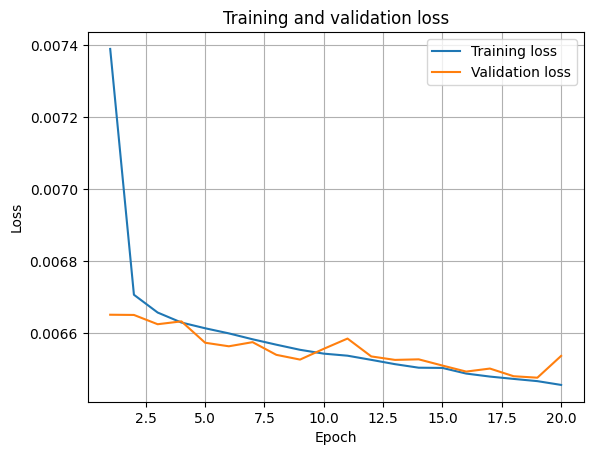

In [48]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

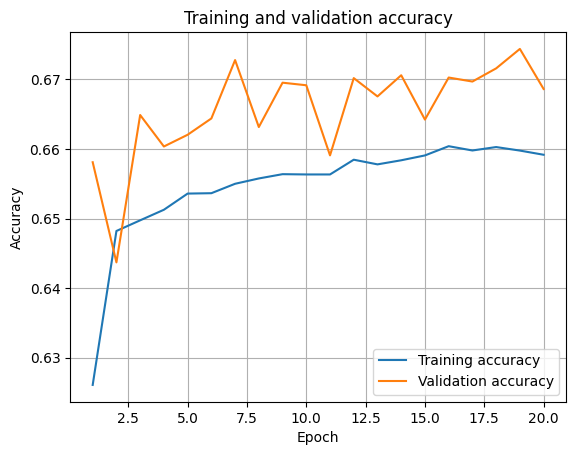

In [49]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Save and load the model

In [50]:
model.save('../models/spotify_playlist.h5')

In [ ]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
model = load_model('../models/spotify_playlist.h5')

# Show the model architecture
if model:
    model.summary()

In [46]:
def predict_next_song(song_uris: list[str]) -> str:
    """Predict the next possible song with help of a neurol network"""
    if not model:
        raise Exception("Model isn't loaded !")

    x = np.zeros((1, playlist_max_len, embedding_dim))
    embedded_songs = [ convert_track_to_vec(song_uri) for song_uri in song_uris]
    x[0] = np.array([embedded_songs])

    next_song = model.predict(x, verbose=0)[0]

    return convert_vec_to_track(np.asarray(next_song).astype('float64'))

In [47]:
playlists = pd.read_json(playlists_filename)
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][1:11]] # need 10 tracks
pred_next_song = predict_next_song(song_uris)
print(pred_next_song, playlists.iloc[1]['tracks'][11]['track_uri'])

spotify:track:0mqcxeYg1b57YjniPNTtQ6 spotify:track:4TTV7EcfroSLWzXRY6gLv6


### Free data

In [ ]:
# free ram
del X_playlists_train
del y_playlists_train
del X_playlists_val
del y_playlists_val
del X_playlists_test
del y_playlists_test

## <span style="color:green">Evaluation of each method</span>

With k-gramm, with k previous songs we will attempted to find the direct next one.
2nd variation: given k songs attempted to find a song that occur in the same playlist after these k songs
3rd variation: given k songs, has the next song a common album / artist. (but none of our methods seems to find tracks only based on artists or album, but more about the surrounding contxt, which could replace a genre parameter)

In [78]:
from typing import Callable
from tqdm import tqdm # progression bar

def eval_baseline_method(X: list[list[str]],
                         y: list[str],
                         method: Callable[[list[str]], str|None]) -> dict[str, int]:
    score = {
        'true': 0,
        'total': len(X)
    }
    
    for index in tqdm(range(len(X))):
        next_song = method(X[index])
        
        if next_song == y[index]:
            score['true'] += 1

    return score

In [38]:
# exec on every opening
# reload tracks and playlists for baseline methods
import pandas as pd

track_uris = pd.read_json(tracks_filename)
playlists = pd.read_json(playlists_filename)

We will need to split our test data with track uris into lists of K-gramms. The same parameters as for the neural network will be used here for evaluating all three methods:
- 2 baseline methods:
    - `get_random_song`: this method should have a bad score, as their is a chace of $\frac{1}{|tracks|}$ to pick the next rigth song.
    - `get_next_song`: this method needs to go throutgh each playlists and should have a better score than the random method. As our tests has shown, the next track is not always the real next one. With not exist combination of tracks, the returned value could be None.
- `get_next_similar_song`: this method use the computed Word2Vec embedding model and cosinus similarity to pick the next song. This method is more flexible than `get_next_song` for unseen combination of tracks.

In [84]:
# test data for evaluation of baseline methods -> 20% of the 20.000 playlists
X_test_baseline, y_test_baseline = playlists_k_gram(playlists_test_baseline, playlist_max_len, step)

In [91]:
## maybe test for unseen sequence of songs too
score = eval_baseline_method(X_test_baseline, y_test_baseline, get_random_next_song)
print(f'random: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [02:15<00:00, 183.00it/s]

random: {'true': 0, 'total': 24770}, Precision: 0.0


In [90]:
score = eval_baseline_method(X_test_baseline, y_test_baseline, get_next_song)
print(f'table scan: {score}, Precision: {score["true"]/score["total"]}')

  0%|          | 23/24770 [00:03<1:10:22,  5.86it/s]


KeyboardInterrupt: 

In [64]:
score = eval_baseline_method(X_test_baseline, y_test_baseline, get_next_similar_song)
print(f'track2vec and cosine similarity: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [08:08<00:00, 50.73it/s]

track2vec and cosine similarity: {'true': 87, 'total': 24770}, Precision: 0.003512313282196205
